# **Final Assessment GenAI with GAN**

## ***Date: 12 June 2024***

1. Problem statement:

Anomaly detection using GAN

2. Dataset: Dataset provided by monika (link: https://github.com/venkatkumarvk/GAN_With_GenAI/blob/main/anomaly_detection_data_extended.csv)

3. Objective: Develop a GAN based model to detect anomalies in provided data (0 or 1)

4. Proposed Approach:

- Data preprocessing
- Generator Network
- Descriminator Network
- GAN Training
- Anamaly Detection
- Evaluation: Accuracy, precision, recall and F1-score

5. Framework: Pytorch

# **1. Import Necessary Library**

In [1]:
# Importing necessary libraries for TensorFlow, pandas, numpy, and matplotlib
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

# Importing the PyTorch library
import torch

# Importing additional libraries for data manipulation, visualization, and machine learning
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split

# Importing PyTorch modules for neural network implementation
from torch import nn, optim
import torch.nn.functional as F
import torch.nn as nn

# Ignoring warnings to enhance code cleanliness
import warnings
warnings.filterwarnings('ignore')


# **2. Data preprocessing**

## Read the dataset and identify the dataset shape

In [2]:
df = pd.read_csv('/content/anomaly_detection_data_extended.csv')
print(f"Dataset shape: {df.shape}")
df.sample(3)


Dataset shape: (1050, 6)


,Feature1,Feature2,Feature3,Feature4,Feature5,Label
107,0.081996,0.457280,1.455822,0.704507,0.789057,0
188,-0.411427,1.153901,-1.869742,-0.388521,0.190424,0
843,-1.134020,-0.346772,-0.585793,-0.221600,-1.440982,0


## Amount of missing data

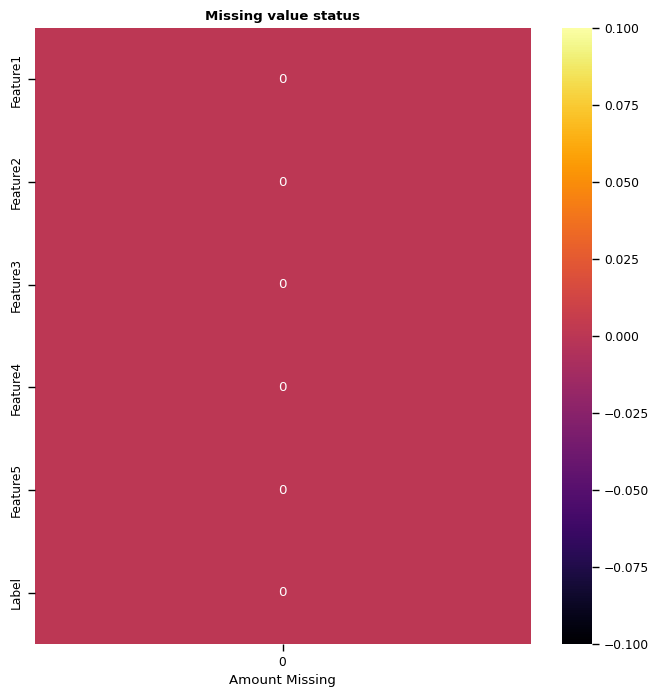

In [3]:
plt.rc('figure',figsize= (8,8))
sns.set_context('paper',font_scale=1)

plt.title('Missing value status',fontweight = 'bold')
ax = sns.heatmap(df.isnull().sum().to_frame(),annot=True,fmt = 'd',cmap = 'inferno')
ax.set_xlabel('Amount Missing')
plt.show()



## EDA

In [4]:
#statistical analysis of data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Feature1,1050.0,-0.019882,1.277914,-5.639757,-0.812861,-0.022794,0.663558,5.541150
Feature2,1050.0,-0.059497,1.193477,-5.812280,-0.772892,-0.022743,0.657066,5.303897
Feature3,1050.0,-0.003619,1.256022,-5.999366,-0.660178,-0.031479,0.691833,5.831899
Feature4,1050.0,0.018515,1.217296,-5.634041,-0.685695,0.014006,0.727188,5.963886
Feature5,1050.0,-0.013019,1.200987,-5.930752,-0.750340,-0.046650,0.707190,5.520143
Label,1050.0,0.047619,0.213060,0.000000,0.000000,0.000000,0.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Feature1  1050 non-null   float64
 1   Feature2  1050 non-null   float64
 2   Feature3  1050 non-null   float64
 3   Feature4  1050 non-null   float64
 4   Feature5  1050 non-null   float64
 5   Label     1050 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 49.3 KB


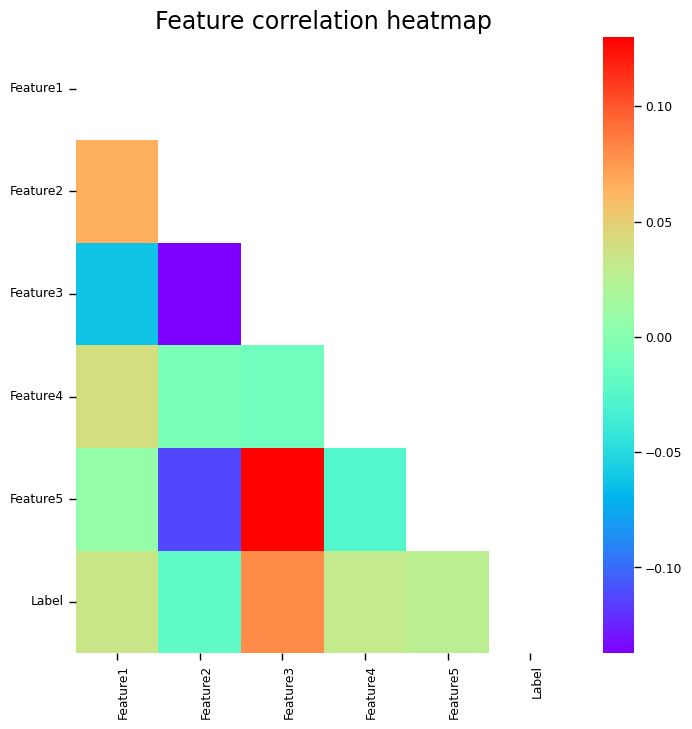

In [6]:
# Plot dataframe
heat = df.corr().round(5)

# Mask to hide upper-right part of plot as it is a duplicate
mask = np.zeros_like(heat)
mask[np.triu_indices_from(mask)] = True

# Making a plot
plt.figure(figsize=(8,8))
ax = sns.heatmap(heat, annot=False, mask=mask, cmap="rainbow", annot_kws={"weight": "bold", "fontsize":13})
ax.set_title("Feature correlation heatmap", fontsize=17)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor", weight="normal")
plt.setp(ax.get_yticklabels(), weight="normal",
         rotation_mode="anchor", rotation=0, ha="right")
plt.show();

In [7]:
df.columns

Index(['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Label'], dtype='object')

In [9]:
df.Label.value_counts()

Label
0    1000
1      50
Name: count, dtype: int64

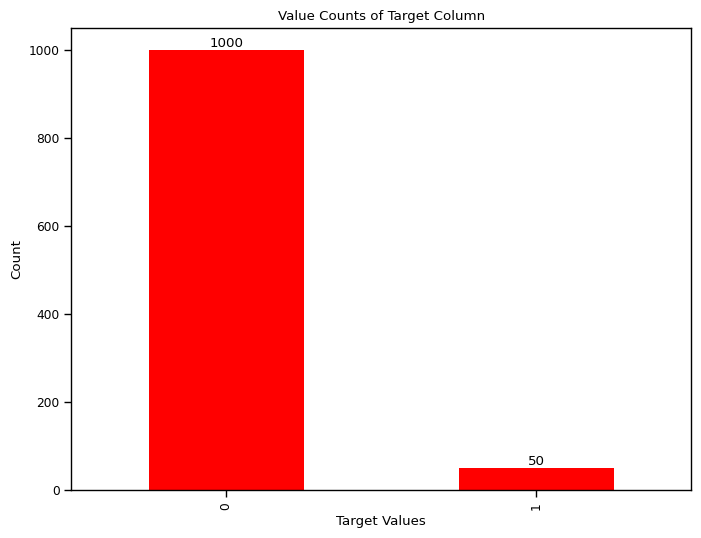

In [17]:
#plot the value count of normal and abnormal values
value_counts = df['Label'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='red')
plt.title('Value Counts of Target Column')
plt.xlabel('Target Values')
plt.ylabel('Count')

# Display the count values on top of the bars
for i, count in enumerate(value_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.show()

## Observation

Our data are Unbalanced manner

In [21]:
classes = df.Label.unique()

def plot_data(data, class_name, ax, n_steps=10):
    # Convert data to a DataFrame
    time_series_df = pd.DataFrame(data)

    # Apply a moving average for smoothing
    smooth_data = time_series_df.rolling(window=n_steps, min_periods=1).mean()

    # Calculate upper and lower bounds for confidence interval
    deviation = time_series_df.rolling(window=n_steps, min_periods=1).std()
    upper_bound = smooth_data + deviation
    lower_bound = smooth_data - deviation

    # Plot the smoothed data
    ax.plot(smooth_data, color='red', linewidth=2)

    # Plot the confidence interval
    ax.fill_between(time_series_df.index, lower_bound[0], upper_bound[0], color='black', alpha=0.2)

    # Set the title
    ax.set_title(class_name)

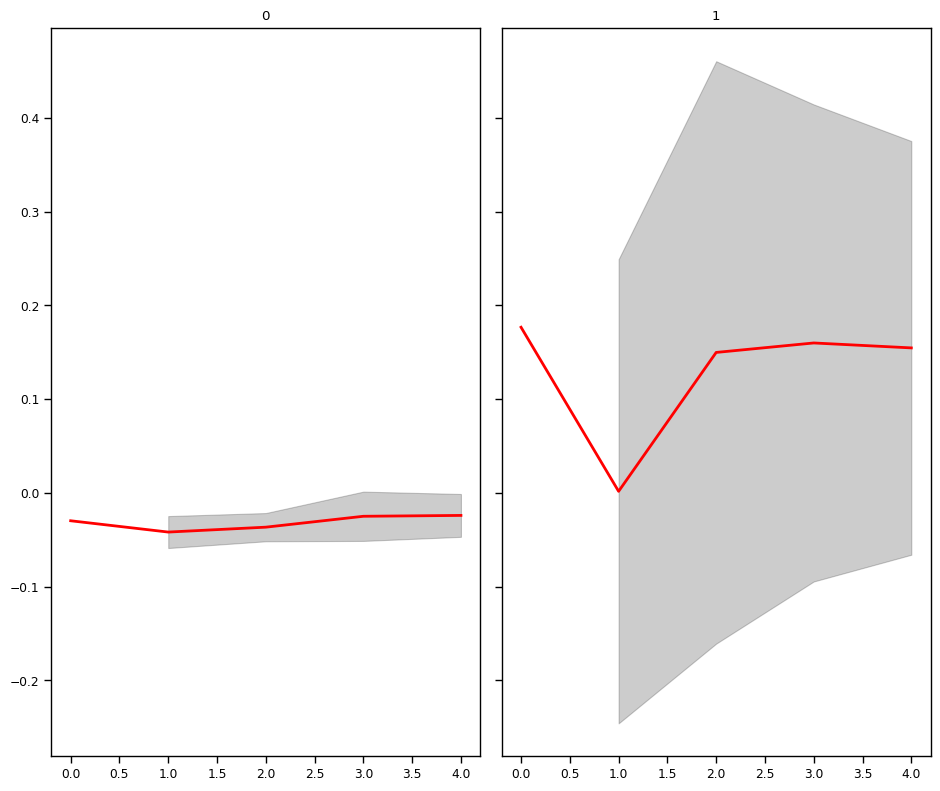

In [22]:
# Plotting setup
fig, axs = plt.subplots(
    nrows=len(classes) // 3 + 1,
    ncols=3,
    sharey=True,
    figsize=(14, 8)
)

# Plot for each class
for i, cls in enumerate(classes):
    ax = axs.flat[i]
    data = df[df.Label == cls].drop(labels='Label', axis=1).mean(axis=0).to_numpy()
    plot_data(data, cls, ax)  # Using 'cls' directly as class name

# Adjust layout and remove extra axes
fig.delaxes(axs.flat[-1])
fig.tight_layout()

plt.show()



# **3. Preparation and Splitting of Data**

In [23]:
normal_df = df[df.Label == 1].drop(labels='Label', axis=1)
print(f"Normal: {normal_df.shape}")

anomaly_df = df[df.Label != 1].drop(labels='Label', axis=1)
print(f"Anomaly: {anomaly_df.shape}")

Normal: (50, 5)
Anomaly: (1000, 5)


In [24]:
# Splitting the Dataset

train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=42
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.30,
  random_state=42
)

# Function to Create a Dataset
def create_dataset(df):
    # Convert DataFrame to a list of sequences, each represented as a list of floats
    sequences = df.astype(np.float32).to_numpy().tolist()

    # Convert sequences to PyTorch tensors, each with shape (sequence_length, 1, num_features)
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

    # Extract dimensions of the dataset
    n_seq, seq_len, n_features = torch.stack(dataset).shape

    # Return the dataset, sequence length, and number of features
    return dataset, seq_len, n_features



In [25]:

# Create the training dataset from train_df
train_dataset, seq_len, n_features = create_dataset(train_df)

# Create the validation dataset from val_df
val_dataset, _, _ = create_dataset(val_df)

# Create the test dataset for normal cases from test_df
test_normal_dataset, _, _ = create_dataset(test_df)

# Create the test dataset for anomalous cases from anomaly_df
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

# **4. Build the model**

Generator and Discriminator network based on LSTM manner

In [26]:
#Encoder
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

#Decoder
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)


In [27]:
# Autoencoder: Combine encoder and decoder
class Autoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Autoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = Autoencoder(seq_len, n_features, 128)
model = model.to(device)

cuda


## Helper function ploting and training the model

In [29]:
def plot_input_reconstruction(model, dataset, epoch):
    model = model.eval()

    plt.figure(figsize=(10, 5))

    # Take the first sequence from the dataset
    seq_true = dataset[0].to(device)
    seq_pred = model(seq_true)

    with torch.no_grad():
        # Squeeze the sequences to ensure they are 1-dimensional
        input_sequence = seq_true.squeeze().cpu().numpy()
        reconstruction_sequence = seq_pred.squeeze().cpu().numpy()

        # Check the shape after squeezing
        if input_sequence.ndim != 1 or reconstruction_sequence.ndim != 1:
            raise ValueError("Input and reconstruction sequences must be 1-dimensional after squeezing.")

        # Plotting the sequences
        plt.plot(input_sequence, label='Input Sequence', color='black')
        plt.plot(reconstruction_sequence, label='Reconstruction Sequence', color='red')
        plt.fill_between(range(len(input_sequence)), input_sequence, reconstruction_sequence, color='gray', alpha=0.5)

        plt.title(f'Input vs Reconstruction - Epoch {epoch}')
        plt.legend()
        plt.show()


In [30]:
def calculate_accuracy(seq_pred, seq_true):
    # Calculate Mean Absolute Error
    mae = torch.mean(torch.abs(seq_pred - seq_true))
    # Calculate accuracy as the inverse of Mean Absolute Error
    accuracy = 1.0 - mae.item() / torch.max(seq_true).item()
    return accuracy

def train_model(model, train_dataset, val_dataset, n_epochs, save_path):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = torch.nn.L1Loss(reduction='sum').to(device)
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    best_accuracy = 0.0

    for epoch in range(1, n_epochs + 1):
        model.train()

        train_losses = []
        for seq_true in train_dataset:
            optimizer.zero_grad()

            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        val_accuracies = []
        model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:
                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)

                loss = criterion(seq_pred, seq_true)
                accuracy = calculate_accuracy(seq_pred, seq_true)

                val_losses.append(loss.item())
                val_accuracies.append(accuracy)

            val_loss = np.mean(val_losses)
            val_accuracy = np.mean(val_accuracies)

            history['train_loss'].append(np.mean(train_losses))
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_accuracy)

            if val_loss < best_loss:
                best_loss = val_loss
                best_accuracy = val_accuracy
                best_model_wts = copy.deepcopy(model.state_dict())
                # Save the best model weights
                print("Saving best model")
                torch.save(model.state_dict(), save_path)

            print(f'Epoch {epoch}: train loss {history["train_loss"][-1]}, val loss {val_loss}, val accuracy {val_accuracy}')

            if epoch == 1 or epoch % 5 == 0:
                plot_input_reconstruction(model, val_dataset, epoch)

    # Load the best model weights before returning
    model.load_state_dict(best_model_wts)
    return model.eval(), history


# **5. Train the model and store the best model in locally**

Saving best model
Epoch 1: train loss 5.856794970376151, val loss 8.774581718444825, val accuracy 0.6298020302551588


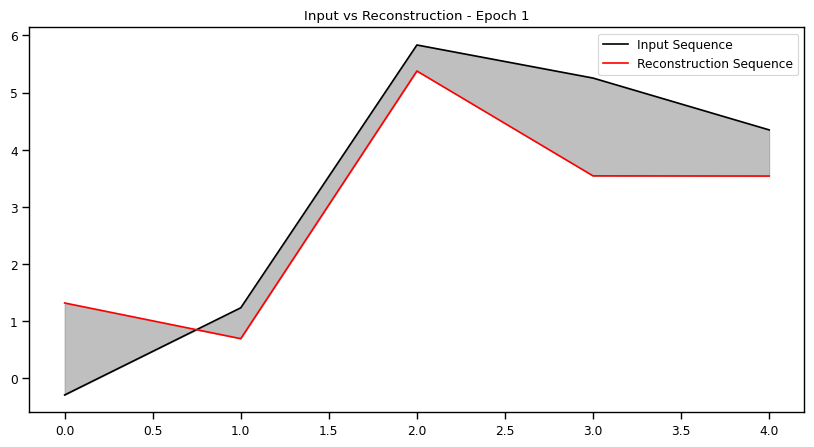

Epoch 2: train loss 5.6680749001957125, val loss 9.29701099395752, val accuracy 0.6104897681299961
Epoch 3: train loss 5.183177970704579, val loss 12.428606986999512, val accuracy 0.49094268042193984
Epoch 4: train loss 4.9908376676695685, val loss 9.92648105621338, val accuracy 0.5852509595514028
Epoch 5: train loss 4.577269928795951, val loss 10.725759506225586, val accuracy 0.5676066915733227


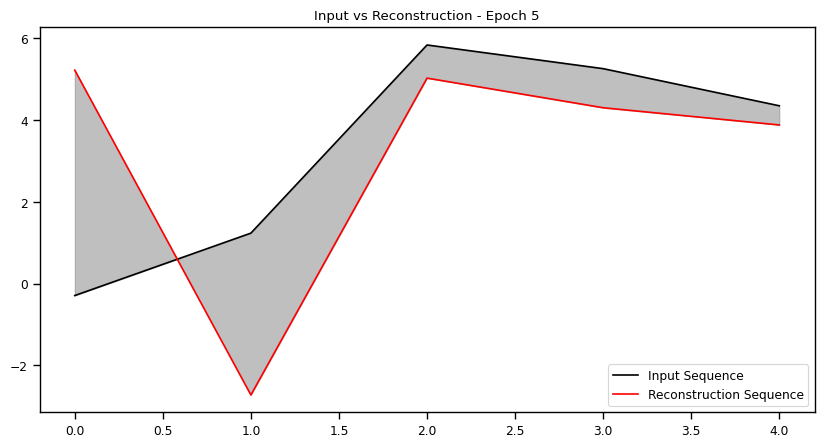

Epoch 6: train loss 4.830590556065242, val loss 11.385651588439941, val accuracy 0.5367402845502631
Epoch 7: train loss 4.839002146607354, val loss 9.474161911010743, val accuracy 0.5963748248758403
Epoch 8: train loss 5.626472217696054, val loss 10.786362075805664, val accuracy 0.5661718766438526
Epoch 9: train loss 4.80134589047659, val loss 9.928353977203368, val accuracy 0.5973740570060265
Epoch 10: train loss 4.457248808372588, val loss 11.545513534545899, val accuracy 0.521340879695696


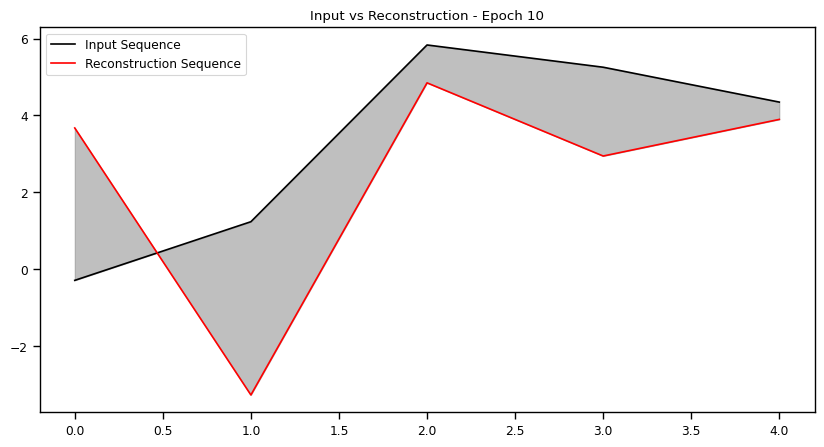

Epoch 11: train loss 4.513114920684269, val loss 9.688354969024658, val accuracy 0.6006941918513686
Epoch 12: train loss 4.28529088695844, val loss 10.278950691223145, val accuracy 0.5753451495427194
Epoch 13: train loss 4.3411504711423605, val loss 9.430684661865234, val accuracy 0.6081112224043045
Epoch 14: train loss 4.031127729586193, val loss 9.725092029571533, val accuracy 0.6047273695114377
Epoch 15: train loss 4.067019008454823, val loss 10.86276626586914, val accuracy 0.5624049052153925


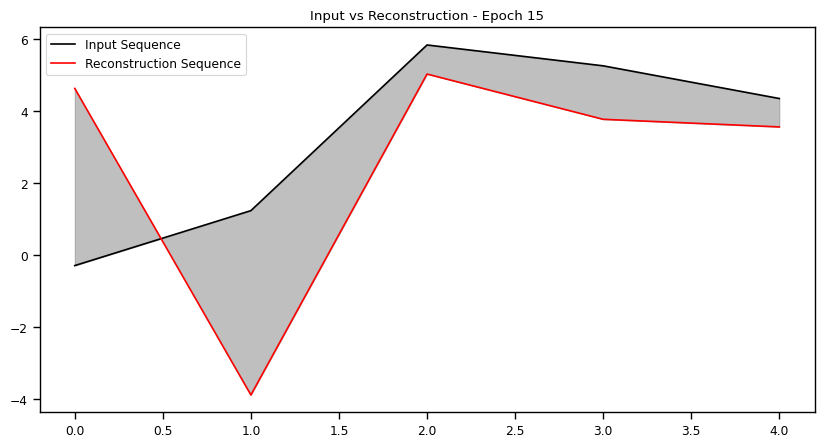

Epoch 16: train loss 3.8415162095001767, val loss 10.274924182891846, val accuracy 0.5917999912750109
Epoch 17: train loss 3.7693818722452437, val loss 10.019830989837647, val accuracy 0.5977705393588046
Epoch 18: train loss 3.8224042370205833, val loss 11.114418411254883, val accuracy 0.5581031078542701
Epoch 19: train loss 3.7778263631321134, val loss 10.776302528381347, val accuracy 0.5670319033043341
Epoch 20: train loss 3.5134436658450534, val loss 10.726072692871094, val accuracy 0.5681416062894626


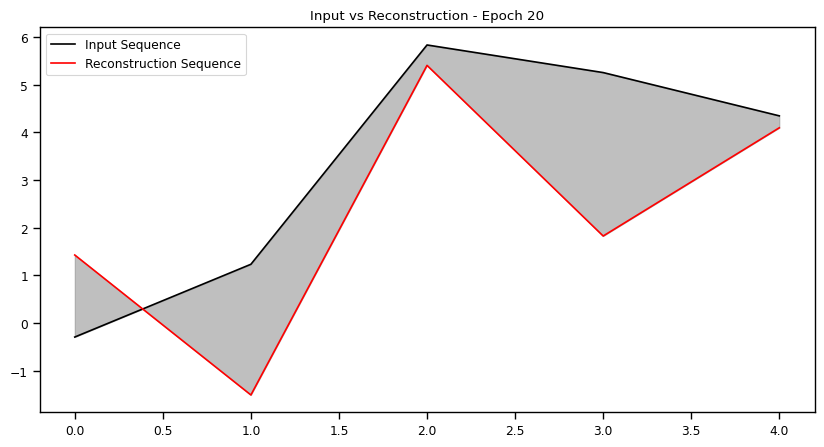

Epoch 21: train loss 3.478763364610218, val loss 11.278813743591309, val accuracy 0.5515486293059622
Epoch 22: train loss 3.294834111418043, val loss 10.912698936462402, val accuracy 0.5611826279553636
Epoch 23: train loss 3.4788373581000736, val loss 10.197689437866211, val accuracy 0.5880678098273863
Epoch 24: train loss 3.1630523148037137, val loss 9.801729202270508, val accuracy 0.609493899214115
Epoch 25: train loss 3.2228749919505346, val loss 10.45005531311035, val accuracy 0.5868654594723661


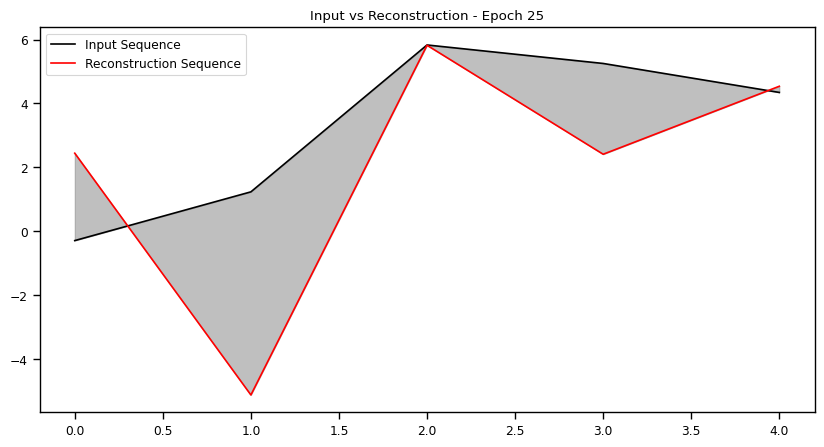

Epoch 26: train loss 3.5945059018475667, val loss 10.205009078979492, val accuracy 0.5894228805620442
Epoch 27: train loss 3.3932926739965166, val loss 10.849644565582276, val accuracy 0.5708456754555179
Epoch 28: train loss 2.9385889172554016, val loss 11.706351280212402, val accuracy 0.5312123382502583
Epoch 29: train loss 2.8777861282939003, val loss 9.919972610473632, val accuracy 0.6041975070891976
Epoch 30: train loss 2.6427206212566015, val loss 11.10044069290161, val accuracy 0.5541879246566626


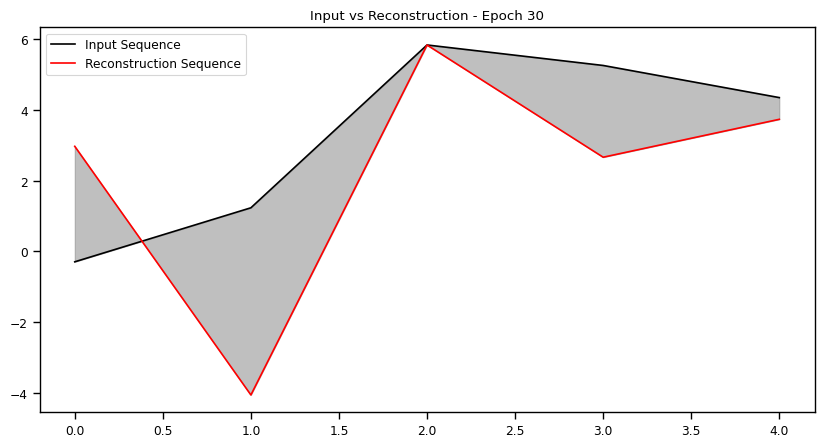

Epoch 31: train loss 2.867449090594337, val loss 11.475749015808105, val accuracy 0.5394714121944114
Epoch 32: train loss 2.6454554980709437, val loss 8.963578033447266, val accuracy 0.6355058416468029
Epoch 33: train loss 2.479052864369892, val loss 9.230328559875488, val accuracy 0.6270986420112974
Epoch 34: train loss 2.580222561245873, val loss 11.010579299926757, val accuracy 0.5579668000040313
Epoch 35: train loss 2.283664982943308, val loss 10.268107795715332, val accuracy 0.5891651122201125


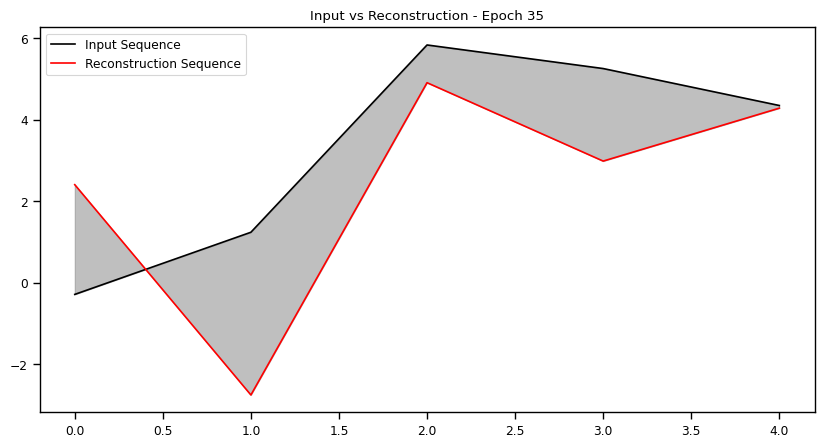

Epoch 36: train loss 2.868883158479418, val loss 9.53311996459961, val accuracy 0.6172693830068825
Epoch 37: train loss 2.5830872527190616, val loss 10.74106731414795, val accuracy 0.5696467696109678
Epoch 38: train loss 3.0641141022954668, val loss 10.944057941436768, val accuracy 0.564816164944929
Epoch 39: train loss 2.754894345998764, val loss 11.057156181335449, val accuracy 0.558793881455843
Epoch 40: train loss 3.1474071130866097, val loss 11.275562286376953, val accuracy 0.5497264908399926


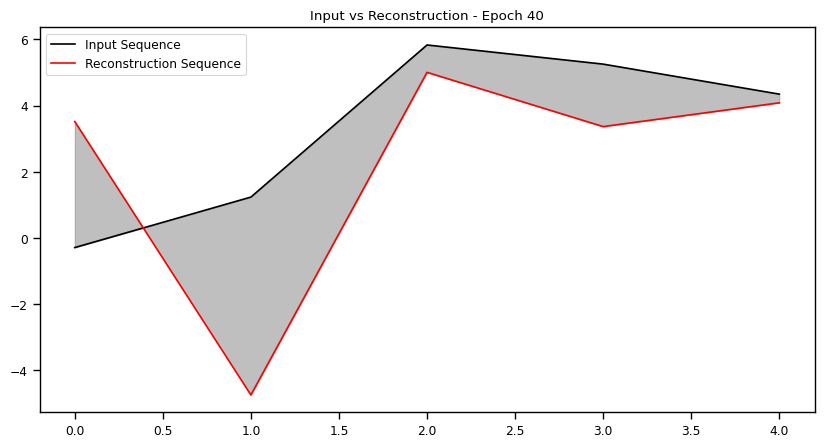

Epoch 41: train loss 2.521461607444854, val loss 9.898742198944092, val accuracy 0.6016687058232331
Epoch 42: train loss 2.5243046964917863, val loss 9.909026718139648, val accuracy 0.6011882422611865
Epoch 43: train loss 2.1374379836377644, val loss 10.864025497436524, val accuracy 0.5650590367973101
Epoch 44: train loss 2.013696626538322, val loss 11.12346715927124, val accuracy 0.5472064925662186
Epoch 45: train loss 2.079693744579951, val loss 11.128617668151856, val accuracy 0.5518865173415616


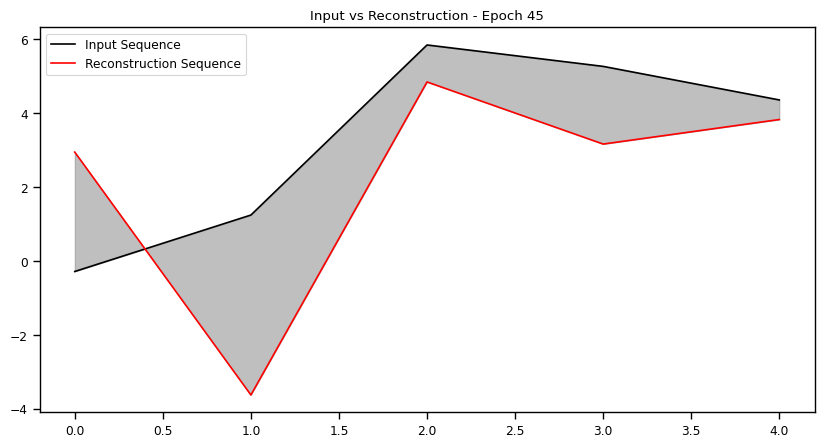

Epoch 46: train loss 2.263020749602999, val loss 11.209594535827637, val accuracy 0.5464399341547572
Epoch 47: train loss 2.2782141977832433, val loss 10.555241203308105, val accuracy 0.5684139455605524
Epoch 48: train loss 2.0788127311638425, val loss 11.04212303161621, val accuracy 0.557404764045679
Epoch 49: train loss 1.7761031531152272, val loss 9.221706676483155, val accuracy 0.6186848934414293
Epoch 50: train loss 2.0965938170750937, val loss 9.01025848388672, val accuracy 0.6347257510580905


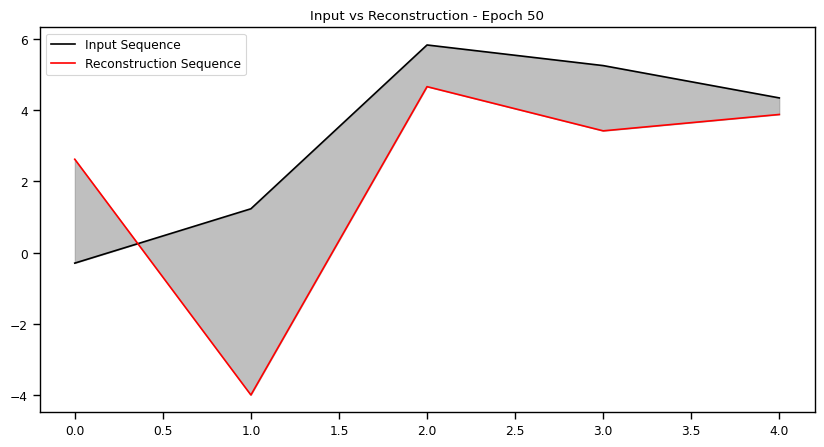

Epoch 51: train loss 1.9429035569940294, val loss 10.86802406311035, val accuracy 0.5590153810033802
Epoch 52: train loss 1.7051067650318146, val loss 10.514235973358154, val accuracy 0.573827794535531
Epoch 53: train loss 1.8579158215295701, val loss 10.654383087158203, val accuracy 0.5750287295964791
Epoch 54: train loss 1.7674654324849446, val loss 10.077262115478515, val accuracy 0.5945886283575845
Epoch 55: train loss 1.7541010067576455, val loss 10.171384811401367, val accuracy 0.5931662924374079


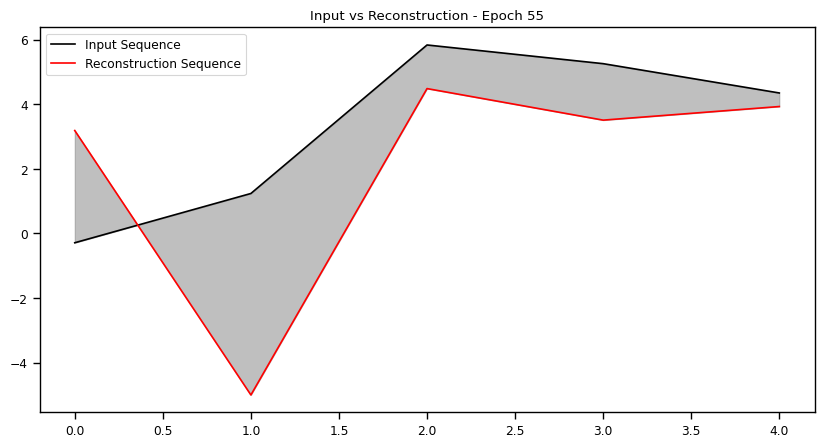

Epoch 56: train loss 1.6972629541442508, val loss 10.68253698348999, val accuracy 0.5636886545326927
Epoch 57: train loss 1.8475866275174277, val loss 11.862808418273925, val accuracy 0.5204352595642103
Epoch 58: train loss 1.7175034554231734, val loss 10.469074153900147, val accuracy 0.5680788473124923
Epoch 59: train loss 1.6635413964589436, val loss 10.702731800079345, val accuracy 0.5691978578186516
Epoch 60: train loss 1.726225258339019, val loss 9.610391807556152, val accuracy 0.6114313892717691


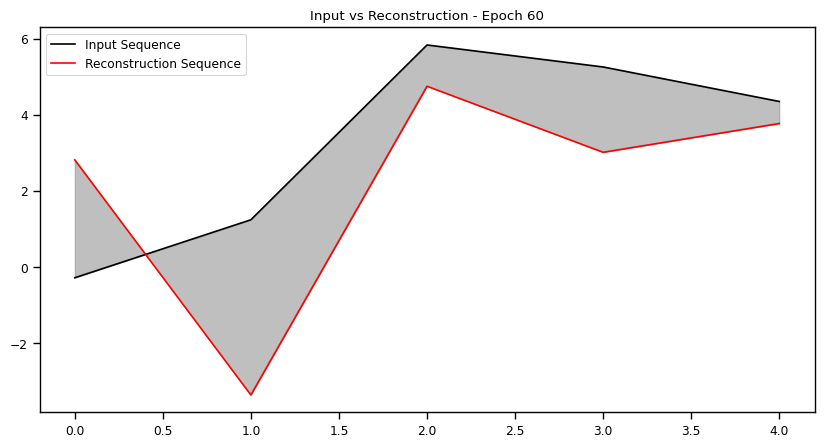

Epoch 61: train loss 1.6168238889603388, val loss 10.13561840057373, val accuracy 0.5939351702232536
Epoch 62: train loss 1.831130707547778, val loss 10.50093879699707, val accuracy 0.5754702254891632
Epoch 63: train loss 1.604269354116349, val loss 10.287497901916504, val accuracy 0.5840149900032107
Epoch 64: train loss 1.6243131515525637, val loss 10.949242401123048, val accuracy 0.5594213501838052
Epoch 65: train loss 1.5034060989107405, val loss 10.711186981201172, val accuracy 0.5686832100797469


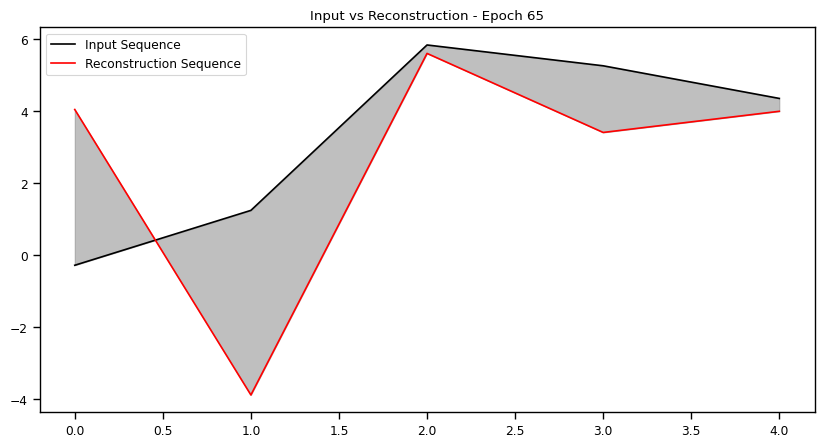

Epoch 66: train loss 1.5574470091433752, val loss 10.822129726409912, val accuracy 0.5648988992480953
Epoch 67: train loss 1.2971918433904648, val loss 9.979510498046874, val accuracy 0.5944382037236894
Epoch 68: train loss 1.5090837074177605, val loss 10.385809898376465, val accuracy 0.5809040210957555
Epoch 69: train loss 1.401585238320487, val loss 11.081742095947266, val accuracy 0.5572422153680618
Epoch 70: train loss 1.237811708734149, val loss 10.773292922973633, val accuracy 0.5687267763767508


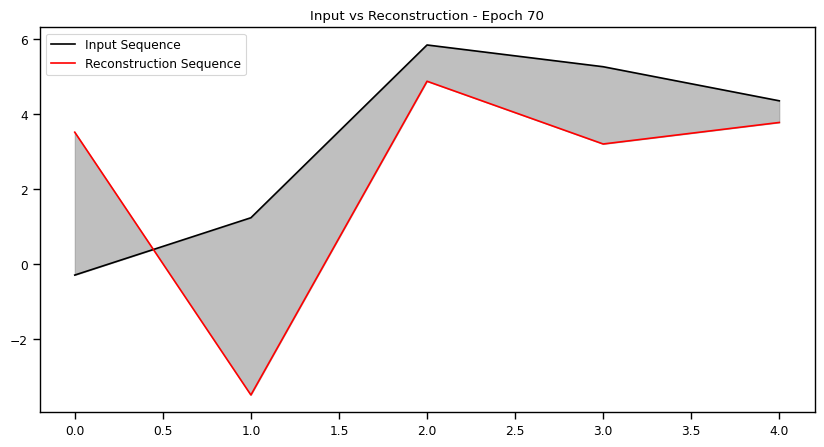

Epoch 71: train loss 1.2011782512778328, val loss 10.900152206420898, val accuracy 0.5592820686822891
Epoch 72: train loss 1.2988330849579401, val loss 11.16835126876831, val accuracy 0.5449330545053469
Epoch 73: train loss 1.319709068962506, val loss 10.476858520507813, val accuracy 0.578485993121512
Epoch 74: train loss 1.2669010701633634, val loss 10.918874359130859, val accuracy 0.5516970017272298
Epoch 75: train loss 1.579344691265197, val loss 11.580449771881103, val accuracy 0.5361663593690436


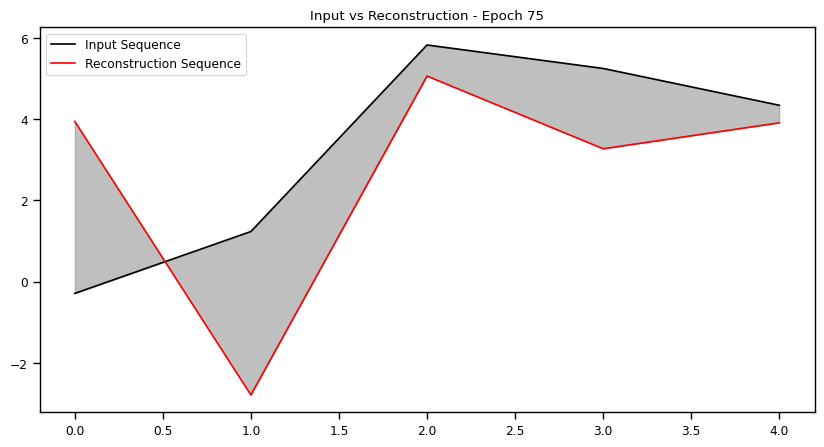

Epoch 76: train loss 1.4772437711556752, val loss 9.468752193450928, val accuracy 0.6127662601378623
Epoch 77: train loss 1.2687999705473583, val loss 9.910154628753663, val accuracy 0.5926405284793113
Epoch 78: train loss 1.2548433556443168, val loss 10.40589714050293, val accuracy 0.5752982524423016
Epoch 79: train loss 1.173124957652319, val loss 10.398564910888672, val accuracy 0.5784223806091908
Epoch 80: train loss 1.309926464444115, val loss 10.8249116897583, val accuracy 0.5582947316545106


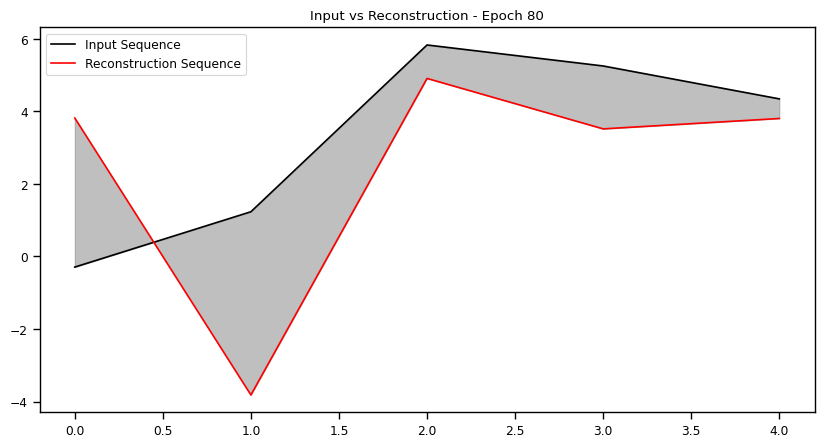

Epoch 81: train loss 1.2062809623423076, val loss 11.072506713867188, val accuracy 0.5557032971955167
Epoch 82: train loss 1.0601256511041097, val loss 10.575727176666259, val accuracy 0.5718279275031298
Epoch 83: train loss 1.1236668747095835, val loss 10.32313232421875, val accuracy 0.58068888159548
Epoch 84: train loss 1.1359182851655143, val loss 10.129425048828125, val accuracy 0.5910639932577979
Epoch 85: train loss 1.197687960806347, val loss 9.654410552978515, val accuracy 0.6082379378424869


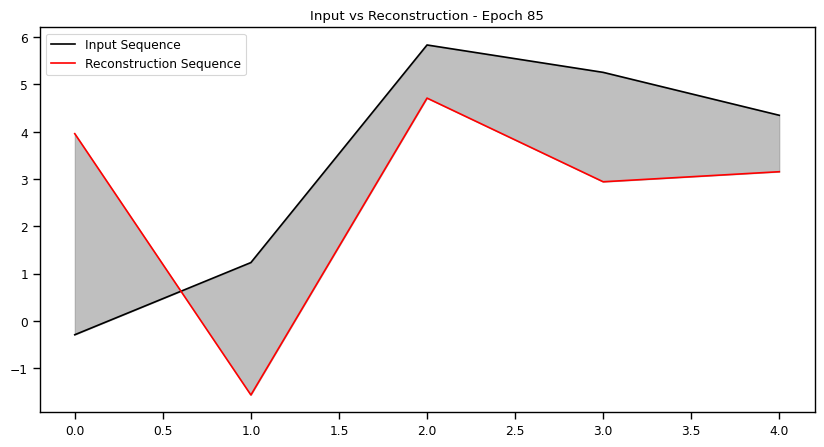

Epoch 86: train loss 1.1717309128670466, val loss 10.276734733581543, val accuracy 0.5814816367563874
Epoch 87: train loss 1.172916371552717, val loss 10.255086326599121, val accuracy 0.5767621817976133
Epoch 88: train loss 1.1266009992077237, val loss 10.175237560272217, val accuracy 0.5881072876403598
Epoch 89: train loss 1.19490385836079, val loss 10.532340145111084, val accuracy 0.5698236734800771
Epoch 90: train loss 1.3342379849581492, val loss 10.311865615844727, val accuracy 0.5780084903154327


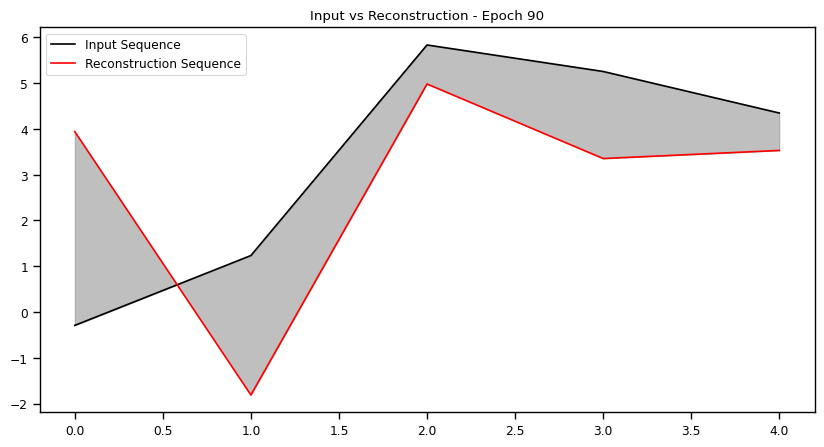

Epoch 91: train loss 1.0572302760112853, val loss 10.541246032714843, val accuracy 0.5717945881094784
Epoch 92: train loss 1.080724149232819, val loss 11.425192737579346, val accuracy 0.5351803072171505
Epoch 93: train loss 1.136375339967864, val loss 10.304205322265625, val accuracy 0.5821230641442127
Epoch 94: train loss 1.1126634585005897, val loss 10.585535049438477, val accuracy 0.5665718052797764
Epoch 95: train loss 1.0263122972987948, val loss 10.492690277099609, val accuracy 0.5764414750431686


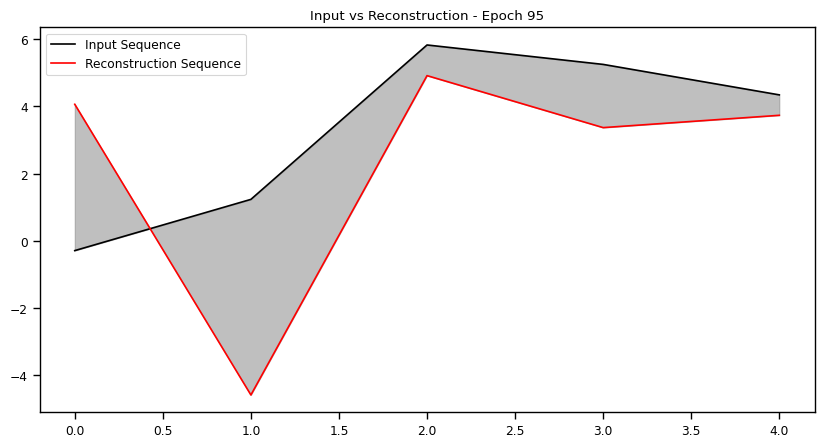

Epoch 96: train loss 0.9305451391708284, val loss 10.75859088897705, val accuracy 0.5648151153004829
Epoch 97: train loss 0.9226798727398827, val loss 10.226962566375732, val accuracy 0.5837457565627533
Epoch 98: train loss 1.0683336215359824, val loss 9.972190666198731, val accuracy 0.5921534705559763
Epoch 99: train loss 1.0263872345288594, val loss 10.602033805847167, val accuracy 0.569269813320503
Epoch 100: train loss 1.1193146918501173, val loss 9.92672700881958, val accuracy 0.5961186272549654


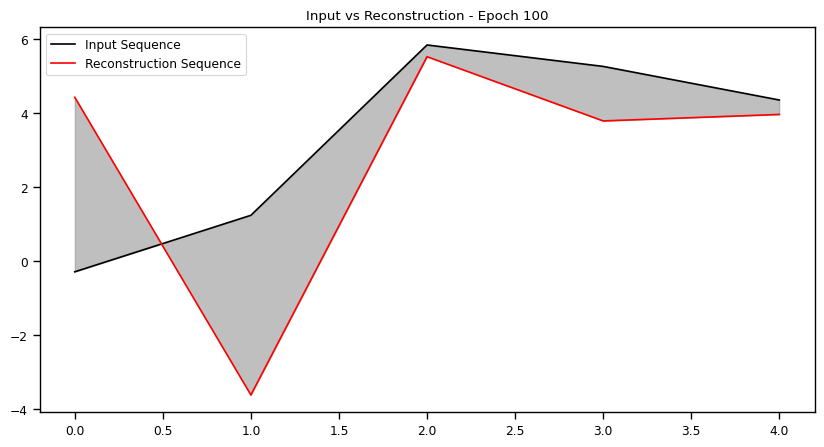

In [33]:
save_path = '/content/best_model.pth'  # Replace with your actual path
model, history = train_model(model, train_dataset, val_dataset, 100, save_path)


## Training vs validation Loss

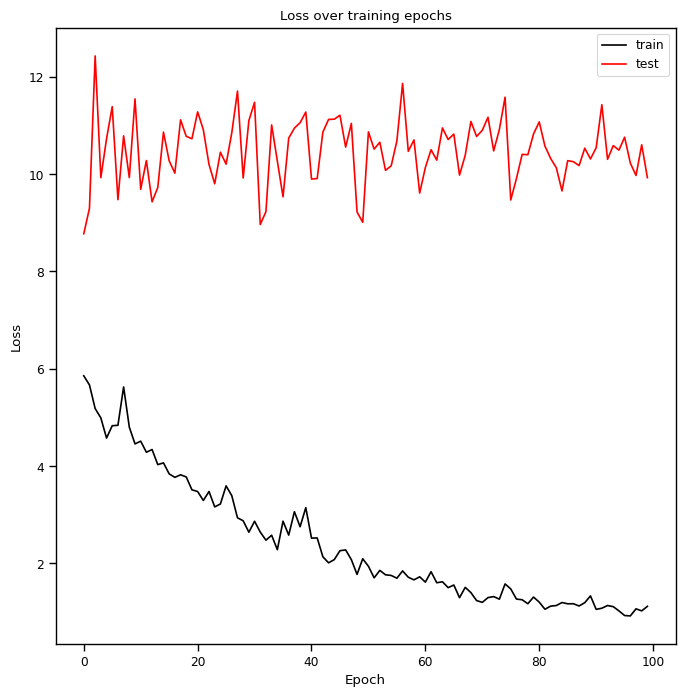

In [34]:
ax = plt.figure().gca()

ax.plot(history['train_loss'],label='Train Loss', color='black')
ax.plot(history['val_loss'],label='Val Loss', color='red')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

Our model is worst at the moment, main reason is unbalanced data. we will tackle this problem. its give the good result

# Anomaly Detection Model: Evaluation and Visualization (Accuracy)


In [35]:
model = Autoencoder(seq_len, n_features, 128)
#use best model
model.load_state_dict(torch.load('/content/best_model.pth'))

model = model.to(device)
model.eval()


Autoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [36]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

def calculate_accuracy(predictions, dataset):
    accuracies = []
    for pred, true in zip(predictions, dataset):
        true = true.cpu().numpy().flatten()
        mae = np.mean(np.abs(pred - true))
        accuracy = 1.0 - mae / np.max(true)
        accuracies.append(accuracy)
    return np.mean(accuracies)


In [37]:
predictions,losses = predict(model, train_dataset)
accuracy = calculate_accuracy(predictions, train_dataset)
print(f"Accuracy of the model on the train dataset: {accuracy}")


Accuracy of the model on the train dataset: 0.15814675027061076


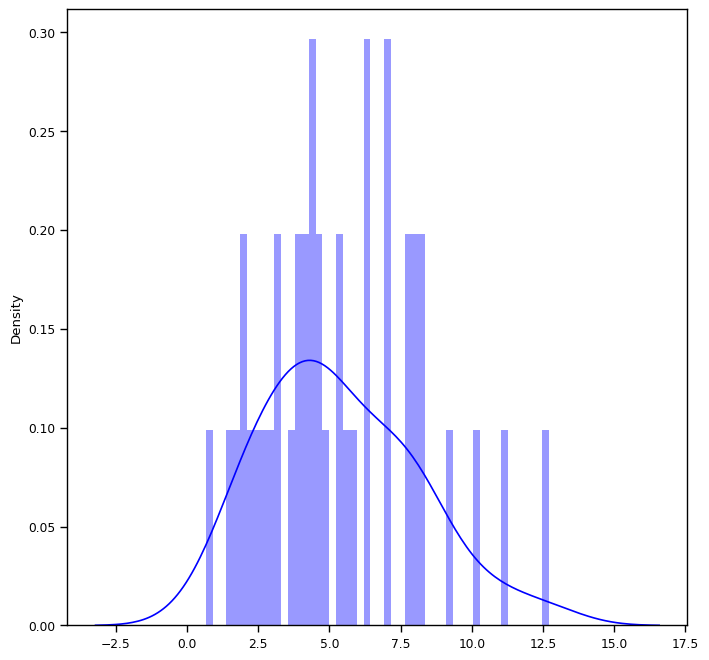

In [38]:
sns.distplot(losses, bins=50, kde=True, label='Train',color='blue');


Accuracy of the model on the validation dataset: 0.39173051714897156


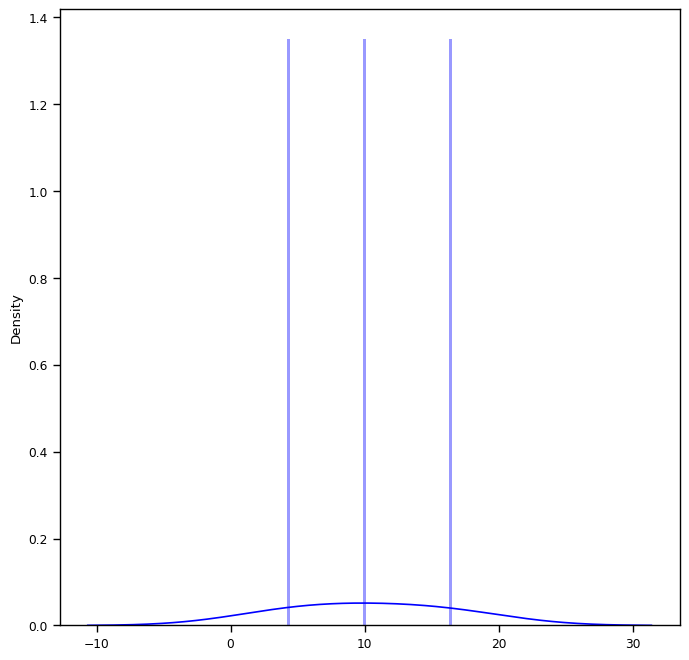

In [39]:
Threshold = 25
predictions, pred_losses = predict(model, test_normal_dataset)
accuracy = calculate_accuracy(predictions, val_dataset)
print(f"Accuracy of the model on the validation dataset: {accuracy}")
sns.distplot(pred_losses, bins=50, kde=True,color='blue');

In [40]:

correct = sum(l <= 25 for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 3/3


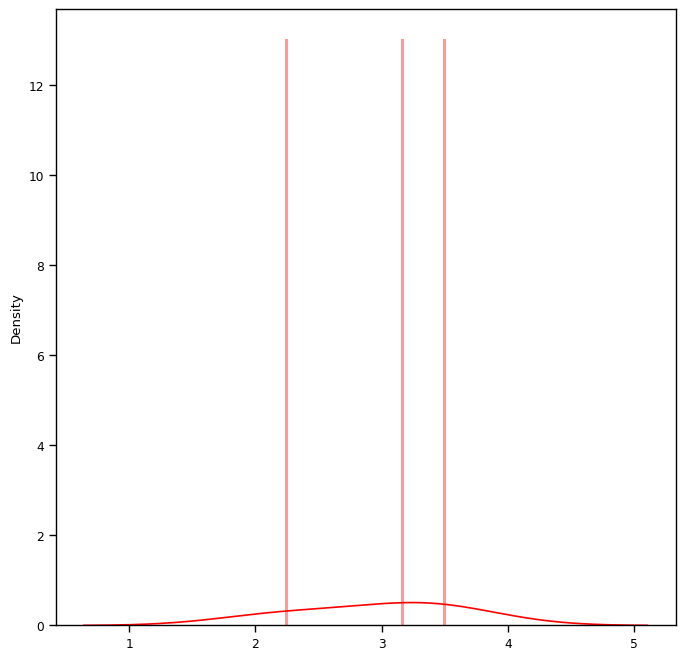

In [41]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True,color='red');


In [42]:

correct = sum(l > 25 for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 0/3


-----------------------------------


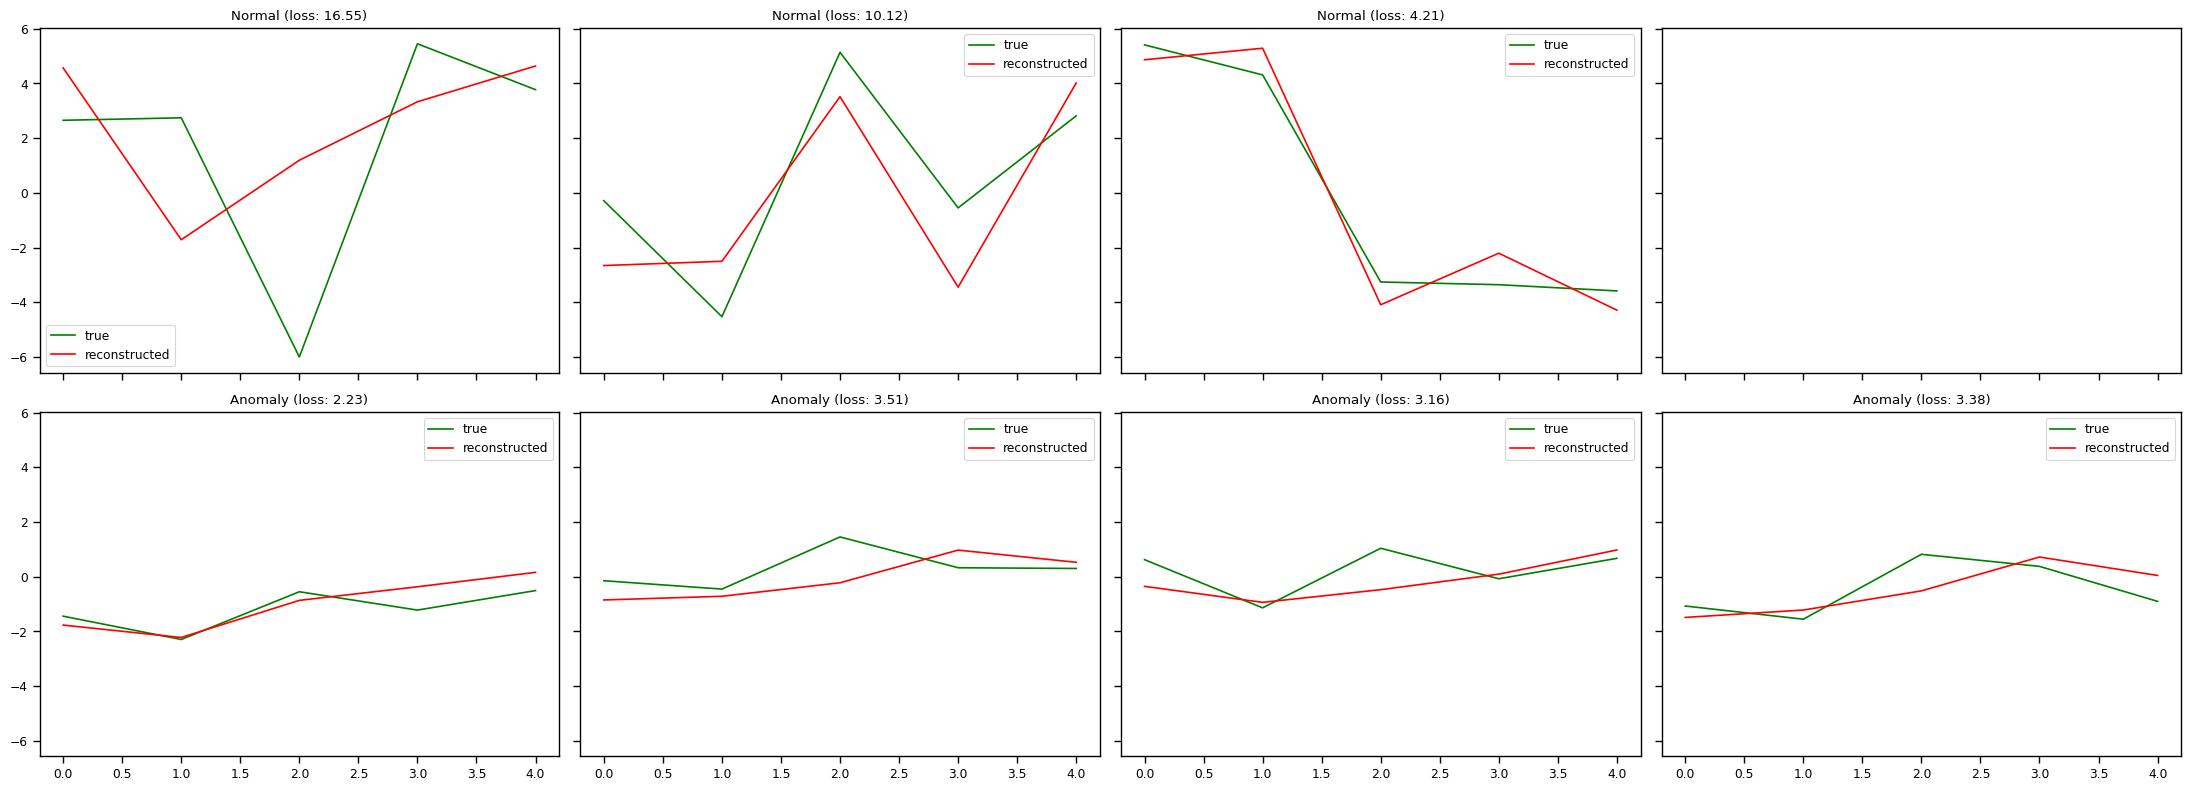

In [43]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true',color='green')
  ax.plot(predictions[0], label='reconstructed',color='red')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

print("-----------------------------------")

fig, axs = plt.subplots(
  nrows=2,
  ncols=4,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:4]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:4]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();

# Final Observation:

1. Increase the epoch and increase the accuracy and reduce the losses
2. Hyperparameter changing is require if you want to increase the accuracy and good result of our project
3. If model not work well in real time, change the architecture and  explore the all hyperparameters change to evaluate the model.

In my developement, Main disadvantage is unbalanced data, so Our model is predict bad result. If you want to develop the good manner. We preprocess to change data in balanced manner

Reference:

1. https://github.com/monika-4dec/AI-Fundamentals-Updated/blob/main/GANs/Day%203_4autoencoder.ipynb
2. https://adamoudad.github.io/posts/ecg-anomaly-detection/